Imports and Read Data

In [1]:
import pandas as pd
import numpy as np

In [2]:
links = pd.read_csv("ml-latest-small/links.csv")
movies = pd.read_csv("ml-latest-small/movies.csv")
ratings = pd.read_csv("ml-latest-small/ratings.csv")
tags = pd.read_csv("ml-latest-small/tags.csv")

Clean Data, Extract Information, Feature Vectorizations

In [3]:
allMovies = movies.copy()
movies["titleWithoutYear"] = movies.title.apply(lambda x: " ".join(x.split(" ")[:-1]))
movies["year"] = movies.title.apply(lambda x: x.strip().split(" ")[-1].replace("(", "").replace(")", ""))

In [4]:
movies = movies[movies["genres"] != "(no genres listed)"]

In [5]:
def check_numeral(n):
    return n.isnumeric() and  len(n) == 4
movies = movies[movies["year"].apply(check_numeral)]

In [6]:
movies.head(2)

movieId             title                                       genres  \
0        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
1        2    Jumanji (1995)                   Adventure|Children|Fantasy   

  titleWithoutYear  year  
0        Toy Story  1995  
1          Jumanji  1995

In [7]:
genres = set([])
for g in movies.genres:
    gs = g.split("|")
    genres = set.union(genres, set(gs))

In [8]:
genres

{'Action',
 'Adventure',
 'Animation',
 'Children',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film-Noir',
 'Horror',
 'IMAX',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War',
 'Western'}

In [9]:
allId = set(allMovies.movieId)
cleanId = set(movies.movieId)
notAllowedIds = set.difference(allId, cleanId)

In [10]:
def vectorizeMovie(mvRec):
    vec = []
    gs = mvRec.genres.split("|")
    for g in genres:
        if g in gs:
            vec.append(1)
        else:
            vec.append(0)
    vec.append(int(mvRec.year))
    vec.append(mvRec.movieId)
    vec.append(mvRec.titleWithoutYear)
    return vec

In [11]:
vectorizedMovies = []
for i in range(len(movies)):
    vectorizedMovies.append(vectorizeMovie(movies.iloc[i]))

In [12]:
vectorMovies = pd.DataFrame()
vectorMovies["name"] = list(map(lambda x: x[-1], vectorizedMovies))
vectorMovies["vector"] = list(map(lambda x: np.array(x[:-2]), vectorizedMovies))
vectorMovies["id"] = list(map(lambda x: x[-2], vectorizedMovies))
vectorMovies = vectorMovies.rename(columns={"id": "movieId"})

In [13]:
mVectors = list(map(lambda x: np.array(x[:-2]).astype(int), vectorizedMovies))

In [14]:
vectorMovies.head(2)

name                                             vector  movieId
0  Toy Story  [0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, ...        1
1    Jumanji  [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...        2

In [15]:
X = np.array(list(vectorMovies["vector"]))

Embedding and Plots

In [16]:
from sklearn.manifold import TSNE
ts = TSNE()
d2 = ts.fit_transform(X)

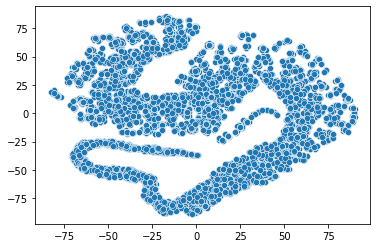

In [17]:
import seaborn as sns
_ = sns.scatterplot(x=d2[:, 0], y=d2[:, 1])

In [18]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=12, random_state=0).fit(X)

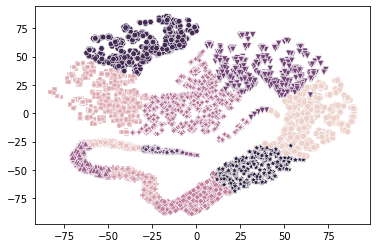

In [19]:
import seaborn as sns
_ = sns.scatterplot(x=d2[:, 0], y=d2[:, 1],  hue=kmeans.labels_, style=kmeans.labels_, legend=None)

Create main DataFrames

In [20]:
ratings = ratings[ratings["movieId"].apply(lambda _id: _id not in notAllowedIds)]

In [21]:
vectorMovies.head(2)

name                                             vector  movieId
0  Toy Story  [0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, ...        1
1    Jumanji  [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...        2

In [22]:
movieCdf = vectorMovies.copy()
dCols = list(genres) + ["year"]
movieCdf[list(genres) + ["year"]] = pd.DataFrame(movieCdf.vector.tolist(), index=movieCdf.index)
movieCdf = movieCdf.drop(labels=["vector"], axis=1)
movieCdf[dCols] = movieCdf[dCols].astype(int)

In [23]:
movieCdf.head(3)

name  movieId  Sci-Fi  Western  Film-Noir  Comedy  Fantasy  \
0         Toy Story        1       0        0          0       1        1   
1           Jumanji        2       0        0          0       0        1   
2  Grumpier Old Men        3       0        0          0       1        0   

   Horror  Drama  Crime  ...  Documentary  Animation  Adventure  Romance  \
0       0      0      0  ...            0          1          1        0   
1       0      0      0  ...            0          0          1        0   
2       0      0      0  ...            0          0          0        1   

   IMAX  Action  War  Children  Musical  year  
0     0       0    0         1        0  1995  
1     0       0    0         1        0  1995  
2     0       0    0         0        0  1995  

[3 rows x 22 columns]

Split to Test-Train and Needed Joins

In [24]:
ratingsAndGenres = ratings.merge(movieCdf, on=["movieId"])
ratingsAndGenres["rating"] = ratingsAndGenres["rating"] / 5

from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(ratingsAndGenres, test_size=0.3, random_state=42)

In [25]:
jMovieCdf = movieCdf.merge(X_train.groupby("movieId").agg({"rating": "mean"}), on="movieId", how="outer")
jMovieCdf["rating"] = jMovieCdf.rating.fillna(0.5)

In [26]:
rCols = dCols + ["rating"]

In [27]:
userMeans = X_train.groupby("userId").mean()

In [28]:
from sklearn.preprocessing import StandardScaler
def std_scale(T):
    return StandardScaler().fit_transform(T)

Recommending Approach I (Case-based KB Recommender):

This Knowledge-Base Approach is implemented as a case-based reasoning system.
User previous ratings are considered as prior cases and by obtaining some feature vector from them, k-Nearest Neighbor Model recommeneds the k most related movies to the user.

Fit NN on processed frame

In [29]:
from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=12).fit(std_scale(jMovieCdf[rCols]))

In [30]:
userMeans[rCols] = std_scale(userMeans[rCols])

Here, for each user set of movies are recommended and ratings of them are checked with test dataset and ratings.
If user rate is higher than 0.5/1(2.5/5) on that, that's a match
Then we calculate the rate (movie sets recommended that user watched movie and like from it) / (movie sets recommended)

In [31]:
matchedRecomms = 0
allRecomms = 0
cRec = 0
mRec = 0
for uId in userMeans.index:
    allRecomms += 1
    vx = userMeans.loc[uId][rCols].to_numpy()

    distances, indices = nbrs.kneighbors([vx])
    movieIds = movieCdf.iloc[indices[0]].movieId.tolist()
    matchs = X_test[(X_test.userId == uId) & (X_test.rating > 0.5)].movieId.tolist()
    sh = set.intersection(set(movieIds), set(matchs))
    cRec += len(movieIds)
    mRec += len(sh)
    if len(sh) > 0:
        matchedRecomms += 1
print(matchedRecomms / allRecomms)

0.13278688524590163


In [32]:
mCols = rCols + ["userId"]
mCols.remove("rating")

Recommending Approach II (Case-based KB Recommender With Better Learning Algorithm):

We fit SupportVectorRegressor on train-set, furthermore one can predict all ratings for movies in the dataset and sort them in order to find movies user will probably rate high, and recommened them.

In [45]:
from sklearn.svm import SVR
reg = SVR(C=1.0, epsilon=0.2)
y = std_scale(X_train["rating"].to_numpy().reshape(-1, 1))
reg.fit(std_scale(X_train[mCols]), y.reshape(1, -1)[0])
yP = reg.predict(std_scale(X_test[mCols]))

In [52]:
yP

array([ 0.60209265, -0.18405361, -0.57137996, ...,  0.33457096,
        0.52107715,  0.25331838])

In [71]:
from sklearn.metrics import mean_squared_error
mean_squared_error(X_test.rating, yP)

0.4738040953706542

Recommending Approach III (Constraint-based KB Recommender With Explicit Specifications):


In [42]:
print(genres)

{'Sci-Fi', 'Western', 'Film-Noir', 'Comedy', 'Fantasy', 'Horror', 'Drama', 'Crime', 'Thriller', 'Mystery', 'Documentary', 'Animation', 'Adventure', 'Romance', 'IMAX', 'Action', 'War', 'Children', 'Musical'}


In [36]:
meanRates = ratingsAndGenres.groupby("movieId").agg({"rating": "mean"})
movieCdfR = movieCdf.merge(meanRates, on="movieId")

In [65]:
from sklearn.neighbors import NearestNeighbors
nbrs2 = NearestNeighbors(n_neighbors=12).fit(movieCdfR[rCols])

In [75]:
def recommendMovieByGenreAndYear(rGenres, year=None, factor=0.05):
    vec = []
    i = 0
    for g in genres:
        if g in rGenres:
            vec.append(1 - i*factor)
            i += 1
        else:
            vec.append(0)
    if year is None:
        year = movieCdfR.year.mean()
    vec.append(year)
    # Highest Rates
    vec.append(1)
    t = np.array(vec)
    distances, indices = nbrs2.kneighbors([t])
    movies = movieCdf.iloc[indices[0]].name.tolist()
    return movies

In [77]:
recommendMovieByGenreAndYear(["Action", "Horror", "Sci-Fi"], year=2000)

['Last Wedding, The (Kivenpyörittäjän kylä)',
 'U-571',
 'Inferno',
 'Boiler Room',
 'Never Cry Wolf',
 'Fubar',
 'Pawnbroker, The',
 'Varsity Blues',
 'And Now... Ladies and Gentlemen...',
 'Rage: Carrie 2, The',
 'Girl on the Bridge, The (Fille sur le pont, La)',
 'Red Planet']

In [89]:
def recommendMovieByGenreAndYearHardConstraint(rGenres, minYear=0, maxYear=None, minRate=0):
    condProp = True
    for g in rGenres:
        condProp = condProp & (movieCdfR[g] == 1)
    if maxYear is not None:
        condProp = condProp & (movieCdfR["year"] <= maxYear)
    condProp = condProp & (movieCdfR["year"] >= minYear)
    condProp = condProp & (movieCdfR["rating"] >= minRate)
    return movieCdfR[condProp].sort_values(by="rating", ascending=False)

In [96]:
recommendMovieByGenreAndYearHardConstraint(["Western", "Sci-Fi"], minYear=1990, minRate=0.5)

name  movieId  Sci-Fi  Western  Film-Noir  \
7318                 Stingray Sam    77931       1        1          0   
9529               The Dark Tower   175197       1        1          0   
1486  Back to the Future Part III     2012       1        1          0   
7490             Cowboys & Aliens    83613       1        1          0   

      Comedy  Fantasy  Horror  Drama  Crime  ...  Animation  Adventure  \
7318       1        0       0      0      0  ...          0          0   
9529       0        1       1      0      0  ...          0          0   
1486       1        0       0      0      0  ...          0          1   
7490       0        0       0      0      0  ...          0          0   

      Romance  IMAX  Action  War  Children  Musical  year    rating  
7318        0     0       0    0         0        1  2009  0.800000  
9529        0     0       0    0         0        0  2017  0.700000  
1486        0     0       0    0         0        0  1990  0.673864  
7490        0     1       1    0         0        0  2011  0.600000  

[4 rows x 23 columns]